In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import os
import sys
import json
from pprint import pprint
import collections
import pickle

import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from matplotlib.lines import Line2D
from matplotlib import colors
from matplotlib import cm as CM

import numpy as np
import ipywidgets as widgets
from matplotlib import gridspec
from scipy.stats import gaussian_kde
from scipy import stats
import tensorflow as tf
from scipy.signal import firwin, freqz

project_root = '..'
sys.path.append(project_root)

from sleeprnn.nn.spectrum import compute_wavelets, apply_wavelets_rectangular, compute_wavelets_noisy
from sleeprnn.helpers import reader, plotter, printer, misc, performer
from sleeprnn.data import utils, stamp_correction
from sleeprnn.detection.feeder_dataset import FeederDataset
from sleeprnn.detection import metrics
from sleeprnn.detection.postprocessor import PostProcessor
from sleeprnn.common import constants, pkeys, viz
from sleeprnn.common.optimal_thresholds import OPTIMAL_THR_FOR_CKPT_DICT

import ipywidgets as widgets
import matplotlib.pyplot as plt
from matplotlib import colors, gridspec
import numpy as np
from scipy.stats import gaussian_kde
from scipy.interpolate import interp1d

project_root = '..'
sys.path.append(project_root)

RESULTS_PATH = os.path.join(project_root, 'results')
COMPARISON_PATH = os.path.join(project_root, 'resources', 'comparison_data')
viz.notebook_full_width()

%matplotlib inline

/home/ntapia/miniconda3/envs/tf/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/ntapia/miniconda3/envs/tf/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/ntapia/miniconda3/envs/tf/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/ntapia/miniconda3/envs/tf/lib/python3.6/site-pack

In [2]:
general_lw = 1.0
signal_lw = 0.8
general_color = viz.GREY_COLORS[9]
signal_color = viz.GREY_COLORS[7]
custom_color = viz.PALETTE['blue'] # viz.PALETTE['cyan'] # viz.PALETTE['blue']
ss_color = viz.PALETTE['blue']
kc_color = viz.PALETTE['green']
pred_color = viz.PALETTE['red']

In [3]:
subject_id = 1
which_kc_stamp = 195
left_context = 10#-2#4
right_context = 10#12#6

dataset = reader.load_dataset(constants.MASS_SS_NAME)
signal = dataset.get_subject_signal(subject_id=subject_id, normalize_clip=False)
stamps_ss = dataset.get_subject_stamps(subject_id=subject_id)
dataset = reader.load_dataset(constants.MASS_KC_NAME)
stamps_kc = dataset.get_subject_stamps(subject_id=subject_id)
fs = dataset.fs

print('%d SS stamps.' % stamps_ss.shape[0])
print('%d KC stamps.' % stamps_kc.shape[0])

segment_size = left_context + right_context
central_sample = stamps_kc[which_kc_stamp, :].mean()
start_sample = int(central_sample - fs * left_context)
end_sample = int(central_sample + fs * right_context)

segment_stamps_ss = utils.filter_stamps(stamps_ss, start_sample, end_sample)
segment_stamps_kc = utils.filter_stamps(stamps_kc, start_sample, end_sample)
segment_signal = signal[start_sample:end_sample]
time_axis = np.arange(start_sample, end_sample) / fs
segment_label_ss = np.zeros(end_sample)
for ss in segment_stamps_ss:
    segment_label_ss[ss[0]:ss[1]+1] = 1
segment_label_ss = segment_label_ss[start_sample:]

Train size: 11. Test size: 4
Train subjects: 
 [1, 3, 5, 7, 9, 10, 11, 14, 17, 18, 19]
Test subjects: 
 [2, 6, 12, 13]
Dataset mass_ss with 15 patients.
Loading from checkpoint... Loaded
Global STD: 16.482042
Mean FFT Scaling of non-testing set: 1.5594099147386842
Per subject FFT scaling / Mean:
S01: 1.0215
S02: 1.0696
S03: 1.0474
S05: 1.0631
S06: 0.9940
S07: 0.9877
S09: 0.9348
S10: 0.8341
S11: 1.0459
S12: 0.7592
S13: 1.0895
S14: 0.9727
S17: 0.9233
S18: 0.9265
S19: 1.2431
Using Custom Scaling Dict
S01: 1.0000
S02: 1.0000
S03: 1.0000
S05: 1.0000
S06: 1.0000
S07: 1.0000
S09: 1.0000
S10: 1.0000
S11: 1.0000
S12: 1.0000
S13: 1.0000
S14: 1.0000
S17: 1.0000
S18: 1.0000
S19: 1.0000
Train size: 11. Test size: 4
Train subjects: 
 [1, 3, 5, 7, 9, 10, 11, 14, 17, 18, 19]
Test subjects: 
 [2, 6, 12, 13]
Dataset mass_kc with 15 patients.
Loading from checkpoint... Loaded
Global STD: 16.482042
1044 SS stamps.
409 KC stamps.


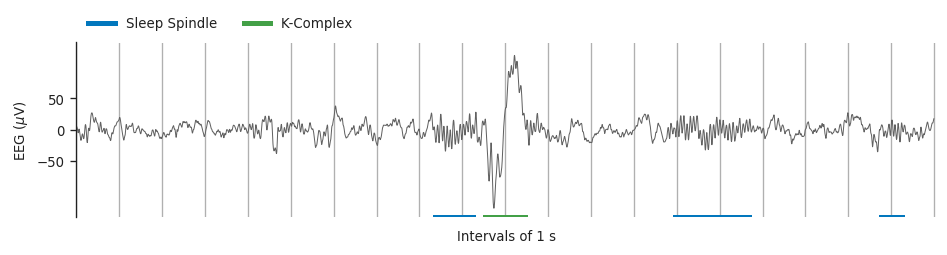

In [4]:
dpi = 120
y_max = 140
y_min = -140
figsize = (8, 2)
alpha = 1
linewidth_mark = 3
ss_correction_right = -0.1

fig, ax = plt.subplots(1, 1, dpi=dpi, figsize=figsize)

ax.plot(time_axis, segment_signal, linewidth=0.6, color=signal_color)
stamp_label_used = False
for stamp in segment_stamps_ss:
    if stamp_label_used:
        label = None
    else:
        label = 'Sleep Spindle'
        stamp_label_used = True
    ax.plot(
        [stamp[0] / fs, stamp[1] / fs + ss_correction_right], [y_min, y_min], label=label, 
        color=ss_color, linewidth=linewidth_mark)
    # ax.fill_between(
    #     stamp / fs, y_mark, -y_mark, 
    #     facecolor=ss_color, alpha=alpha, label=label)
stamp_label_used = False
for stamp in segment_stamps_kc:
    if stamp_label_used:
        label = None
    else:
        label = 'K-Complex'
        stamp_label_used = True
    ax.plot(
        stamp / fs, [y_min, y_min], label=label, 
        color=kc_color, linewidth=linewidth_mark)
    # ax.fill_between(
    #     stamp / fs, y_mark, -y_mark, 
    #     facecolor=kc_color, alpha=alpha, label=label)
ax.set_xlabel('Intervals of 1 s', fontsize=viz.FONTSIZE_GENERAL)
ax.set_ylabel('EEG ($\mu$V)', fontsize=viz.FONTSIZE_GENERAL)
ax.set_yticks([-50, 0, 50])
ax.set_xlim([time_axis[0], time_axis[-1]+0.05])
ax.set_ylim([y_min, y_max])
ax.set_xticks([])
ax.set_xticks(np.arange(time_axis[0], time_axis[-1]+0.1, 1), minor=True)
ax.grid(b=True, axis='x', which='minor')
lg = ax.legend(loc='lower left', bbox_to_anchor=(0,1), ncol=2, fontsize=viz.FONTSIZE_GENERAL, frameon=False)
ax.tick_params(labelsize=viz.FONTSIZE_GENERAL)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_visible(False)
# ax.spines['left'].set_visible(False)
ax.tick_params(axis='x', which='both',length=0)
for lh in lg.legendHandles:
    lh.set_alpha(min(2 * alpha, 1.0))

# Change color of plot
plt.setp(lg.get_texts(), color=general_color)
ax = plotter.set_axis_color(ax, general_color)
plt.tight_layout()

# plt.savefig("ss_kc_example.eps")

plt.show()

# Determination of FIR size given cutoff frequency

In [5]:
def fir_freq_response(fir_filter, fs):
    w, h = freqz(fir_filter)
    resp_freq = w * fs / (2 * np.pi)
    resp_amp = abs(h)
    return resp_freq, resp_amp

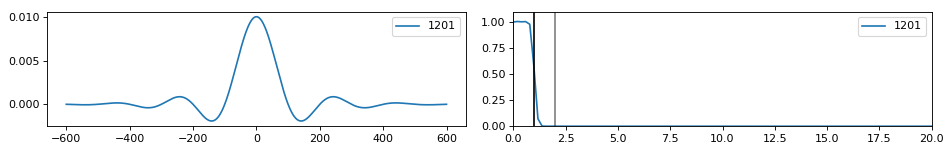

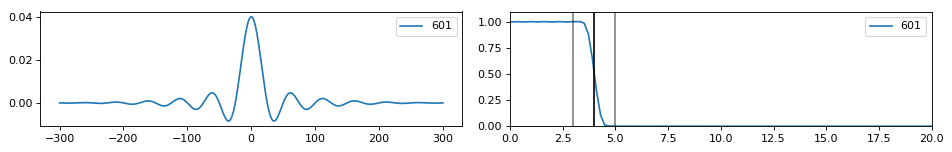

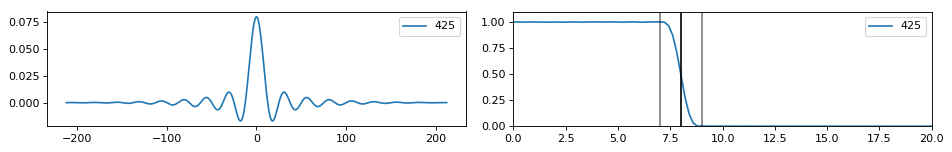

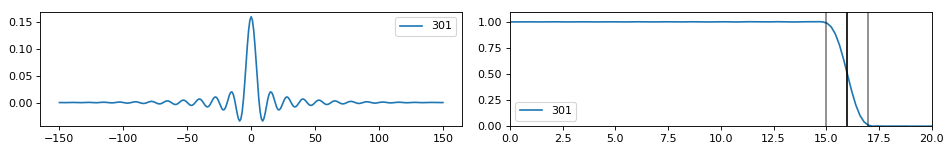

In [6]:
# freq_range_plot = 3
wave_expansion_factor = 0.5
for cutoff in [1, 4, 8, 16]:
    fig, ax = plt.subplots(1, 2, figsize=(12, 2), dpi=80)
    for numtaps_ref in [6 * fs]:
        # numtaps = 2 * int(numtaps_ref / (2 * cutoff)) + 1
        numtaps = numtaps_ref / (cutoff ** wave_expansion_factor)
        numtaps = 2 * int(numtaps // 2) + 1 
        k_array = np.arange(numtaps) - numtaps // 2
        auto_filter = firwin(numtaps, cutoff=cutoff, window="hamming", fs=fs).astype(np.float32)
        auto_resp_freq, auto_resp_amp = fir_freq_response(auto_filter, fs)
        ax[0].plot(k_array, auto_filter, label="%d" % numtaps)
        ax[1].plot(auto_resp_freq, auto_resp_amp, label="%d" % numtaps)
        ax[1].set_xlim([0, 20])
        #ax[1].set_xlim([max(cutoff - freq_range_plot, 0), cutoff + freq_range_plot])
        ax[1].set_ylim([1e-5, 1.1])
        # ax[1].set_yscale("log")
    ax[1].axvline([cutoff], color="k")
    ax[1].axvline([cutoff-1], color="k", alpha=0.5)
    ax[1].axvline([cutoff+1], color="k", alpha=0.5)
    ax[0].legend()
    ax[1].legend()
    plt.tight_layout()
    plt.show()

# Wave editing

In [94]:
def apply_fir_filter_tf(signal, kernel):
    """For single signal, not batch"""
    signal = tf.reshape(signal, shape=[1, 1, -1, 1])
    kernel = tf.reshape(kernel, shape=[1, -1, 1, 1])
    new_signal = tf.nn.conv2d(
        input=signal, filter=kernel, strides=[1, 1, 1, 1], padding="SAME")
    new_signal = new_signal[0, 0, :, 0]
    return new_signal


def random_window_tf(signal_size, window_min_size, window_max_size):
    window_size = tf.random.uniform([], minval=window_min_size, maxval=window_max_size)
    start_sample = tf.random.uniform([], minval=0, maxval=(signal_size - window_size - 1))
    k_array = np.arange(signal_size)
    offset_1 = start_sample + 0.1 * window_size
    offset_2 = start_sample + 0.9 * window_size
    scaling = 0.1 * window_size / 4
    window_onset = tf.math.sigmoid((k_array - offset_1) / scaling)
    window_offset = tf.math.sigmoid((k_array - offset_2) / scaling)
    window = window_onset - window_offset
    return window


def random_smooth_function_tf(signal_size, function_min_val, function_max_val, lp_filter_size):
    lp_filter = np.hanning(lp_filter_size).astype(np.float32)
    lp_filter /= lp_filter.sum()
    noise_vector = tf.random.uniform([signal_size], minval=-1, maxval=1)
    noise_vector = apply_fir_filter_tf(noise_vector, lp_filter)
    # Set noise to [0, 1] range
    min_val = tf.reduce_min(noise_vector)
    max_val = tf.reduce_max(noise_vector)
    noise_vector = (noise_vector - min_val) / (max_val - min_val)
    # Set to [function_min_val, function_max_val] range
    noise_vector = function_min_val + noise_vector * (function_max_val - function_min_val)
    return noise_vector


def generate_wave_tf(
    signal_size,  # Number of samples
    fs,  # [Hz]
    max_amplitude,  # signal units
    min_frequency,  # [Hz]
    max_frequency,  # [Hz]
    frequency_deviation,  # [Hz]
    min_duration,  # [s]
    max_duration,  # [s]
    frequency_lp_filter_duration=0.5,  # [s]
    amplitude_lp_filter_duration=0.5,  # [s]
    labels_for_masking=None,
    mask_lp_filter_duration=0.2  # [s]
):
    # This is ok to be numpy
    window_min_size = int(fs * min_duration)
    window_max_size = int(fs * max_duration)
    frequency_lp_filter_size = int(fs * frequency_lp_filter_duration)
    amplitude_lp_filter_size = int(fs * amplitude_lp_filter_duration)
    mask_lp_filter_size = int(fs * mask_lp_filter_duration)
    time_template = np.arange(signal_size) / fs
    # Oscillation
    central_freq = tf.random.uniform([], minval=min_frequency, maxval=max_frequency)
    lower_freq = central_freq - frequency_deviation
    upper_freq = central_freq + frequency_deviation
    wave_freq = random_smooth_function_tf(signal_size, lower_freq, upper_freq, frequency_lp_filter_size)
    wave_phase = 2 * np.pi * tf.math.cumsum(wave_freq) / fs 
    oscillation = tf.math.cos(wave_phase)
    # Amplitude
    amplitude_high = tf.random.uniform([], minval=0, maxval=max_amplitude)
    amplitude_low = tf.random.uniform([], minval=0, maxval=amplitude_high)
    amplitude = random_smooth_function_tf(signal_size, amplitude_low, amplitude_high, amplitude_lp_filter_size)
    # Window
    window = random_window_tf(signal_size, window_min_size, window_max_size)
    # Total wave
    generated_wave = window * amplitude * oscillation
    # Optional masking with labels
    if labels_for_masking is not None:
        soft_mask = generate_soft_mask_tf(labels_for_masking, mask_lp_filter_size)
        generated_wave = generated_wave * soft_mask
    return generated_wave


def lowpass_tf(signal, fs, cutoff, filter_duration_ref=6, wave_expansion_factor=0.5):
    numtaps = fs * filter_duration_ref / (cutoff ** wave_expansion_factor)
    numtaps = int(2 * (numtaps // 2) + 1)  # ensure odd numtaps
    lp_kernel = firwin(numtaps, cutoff=cutoff, window="hamming", fs=fs).astype(np.float32)
    lp_kernel /= lp_kernel.sum()
    new_signal = apply_fir_filter_tf(signal, lp_kernel)
    return new_signal


def highpass_tf(signal, fs, cutoff, filter_duration_ref=6, wave_expansion_factor=0.5):
    numtaps = fs * filter_duration_ref / (cutoff ** wave_expansion_factor)
    numtaps = int(2 * (numtaps // 2) + 1)  # ensure odd numtaps
    lp_kernel = firwin(numtaps, cutoff=cutoff, window="hamming", fs=fs).astype(np.float32)
    lp_kernel /= lp_kernel.sum()
    # HP = delta - LP
    hp_kernel = -lp_kernel
    hp_kernel[numtaps//2] += 1
    new_signal = apply_fir_filter_tf(signal, hp_kernel)
    return new_signal


def bandpass_tf(signal, fs, lowcut, highcut, filter_duration_ref=6, wave_expansion_factor=0.5):
    new_signal = highpass_tf(
        signal, fs, lowcut, filter_duration_ref, wave_expansion_factor)
    new_signal = lowpass_tf(
        new_signal, fs, highcut, filter_duration_ref, wave_expansion_factor)
    return new_signal


def generate_soft_mask_tf(labels, lp_filter_size):
    labels = tf.cast(labels, tf.float32)
    # Enlarge labels
    expand_filter = np.ones(lp_filter_size).astype(np.float32)
    expanded_labels = apply_fir_filter_tf(labels, expand_filter)
    expanded_labels = tf.clip_by_value(expanded_labels, 0, 1)
    # Now filter
    lp_filter = np.hanning(lp_filter_size).astype(np.float32)
    lp_filter /= lp_filter.sum()
    soft_mask = 1 - apply_fir_filter_tf(expanded_labels, lp_filter)
    return soft_mask


def generate_anti_wave_tf(
    signal, 
    signal_size, # number of samples
    fs,  # [Hz]
    lowcut,  # [Hz]
    highcut,  # [Hz]
    min_duration,  # [s]
    max_duration,  # [s]
    max_attenuation=1,  # [0, 1]
    labels_for_masking=None,
    mask_lp_filter_duration=0.2  # [s]
):
    # This is ok to be numpy
    window_min_size = int(fs * min_duration)
    window_max_size = int(fs * max_duration)
    mask_lp_filter_size = int(fs * mask_lp_filter_duration)
    # Oscillation (opposite sign of band signal) and attenuation factor
    if lowcut is None:
        oscillation = -lowpass_tf(signal, fs, highcut)
    elif highcut is None:
        oscillation = -highpass_tf(signal, fs, lowcut)
    else:
        oscillation = -bandpass_tf(signal, fs, lowcut, highcut)
    attenuation_factor = tf.random.uniform([], minval=0, maxval=max_attenuation)
    # Window
    window = random_window_tf(signal_size, window_min_size, window_max_size)
    # Total wave
    generated_wave = window * attenuation_factor * oscillation
    # Optional masking with labels
    if labels_for_masking is not None:
        soft_mask = generate_soft_mask_tf(labels_for_masking, mask_lp_filter_size)
        generated_wave = generated_wave * soft_mask
    return generated_wave

### Check filters

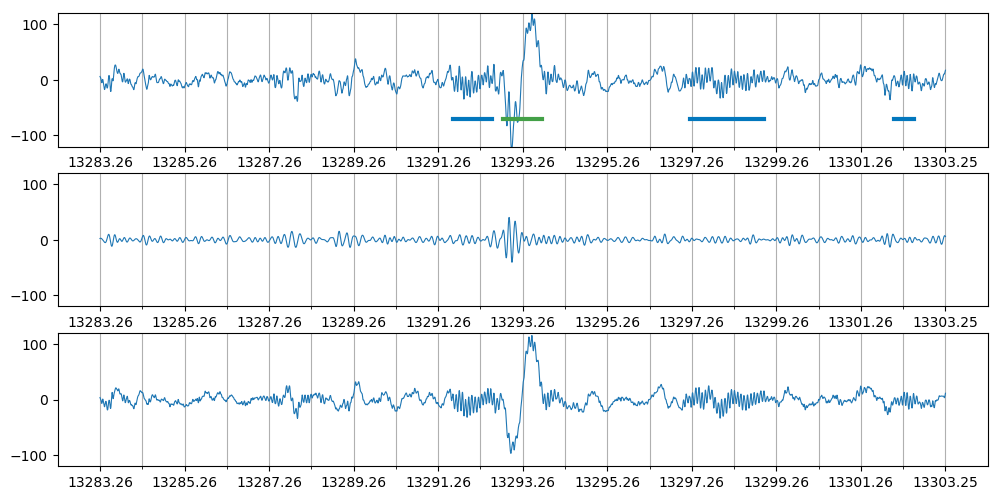

In [8]:
tf.reset_default_graph()
filt_signal_tf = segment_signal
# filt_signal_tf = highpass_tf(filt_signal_tf, fs, cutoff=8)
# filt_signal_tf = lowpass_tf(filt_signal_tf, fs, cutoff=2)
filt_signal_tf = bandpass_tf(filt_signal_tf, fs, 4, 10)

with tf.Session() as sess:
    filt_signal = sess.run(filt_signal_tf)
fig, axes = plt.subplots(3, 1, figsize=(12, 6), dpi=100)
axes[0].plot(time_axis, segment_signal, linewidth=0.8)
axes[1].plot(time_axis, filt_signal, linewidth=0.8)
axes[2].plot(time_axis, segment_signal - filt_signal, linewidth=.8)
for stamp in segment_stamps_ss:
    axes[0].plot(
        [stamp[0] / fs, stamp[1] / fs + ss_correction_right], [-70, -70], 
        color=ss_color, linewidth=linewidth_mark)
for stamp in segment_stamps_kc:
    axes[0].plot(
        stamp / fs, [-70, -70],
        color=kc_color, linewidth=linewidth_mark)
for ax in axes:
    ax.set_xticks(np.linspace(time_axis[0], time_axis[-1], 21), minor=True)
    ax.set_xticks(np.linspace(time_axis[0], time_axis[-1], 11))
    ax.grid(axis="x", which="minor")
    ax.set_ylim([-120,120])
plt.show()

### Check soft mask

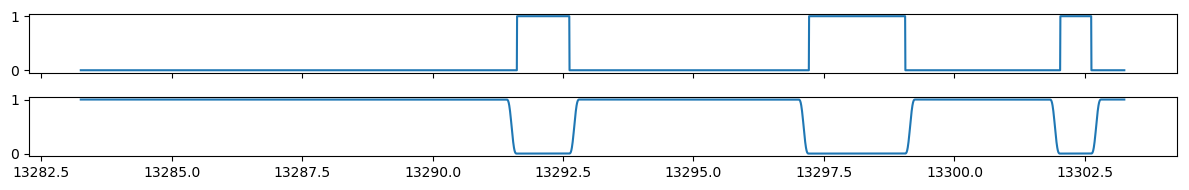

In [46]:
tf.reset_default_graph()
lp_filter_size = int(0.2 * fs)
soft_mask_tf = generate_soft_mask_tf(segment_label_ss, lp_filter_size)

with tf.Session() as sess:
    soft_mask = sess.run(soft_mask_tf)

fig, axes = plt.subplots(2, 1, figsize=(12, 2), dpi=100, sharex=True)
axes[0].plot(time_axis, segment_label_ss)
axes[1].plot(time_axis, soft_mask)
# axes[0].set_xlim([13290, 13295])
plt.tight_layout()
plt.show()

### Random wave generation

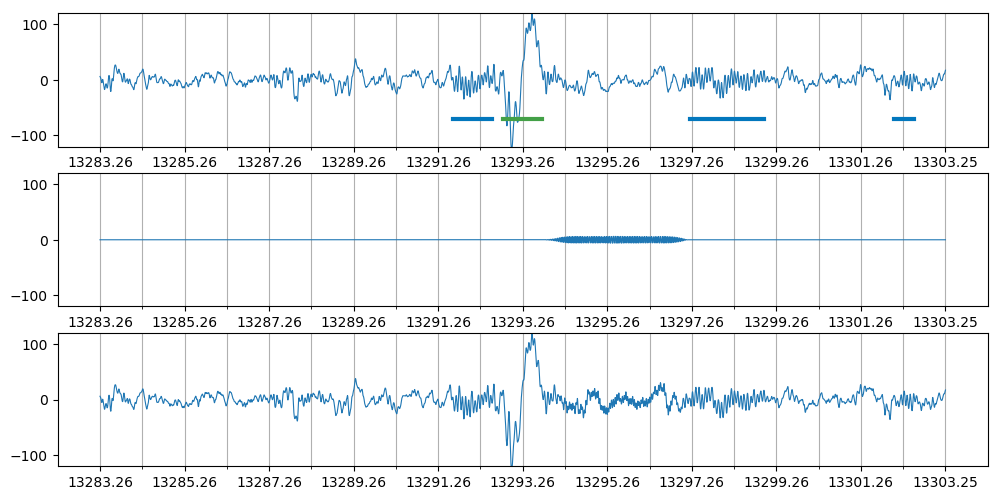

In [65]:
tf.reset_default_graph()
random_wave_tf = generate_wave_tf(
    segment_signal.size, fs,
    max_amplitude=10,  
    min_frequency=18,  #8
    max_frequency=25,  #10
    frequency_deviation=2,  #2  
    min_duration=1,  #1
    max_duration=5,  #5
    labels_for_masking=segment_label_ss
)
new_signal_tf = random_wave_tf + segment_signal

with tf.Session() as sess:
    new_signal, random_wave = sess.run([new_signal_tf, random_wave_tf])
fig, axes = plt.subplots(3, 1, figsize=(12, 6), dpi=100)
axes[0].plot(time_axis, segment_signal, linewidth=0.8)
axes[1].plot(time_axis, random_wave, linewidth=0.8)
axes[2].plot(time_axis, new_signal, linewidth=.8)
for stamp in segment_stamps_ss:
    axes[0].plot(
        [stamp[0] / fs, stamp[1] / fs + ss_correction_right], [-70, -70], 
        color=ss_color, linewidth=linewidth_mark)
for stamp in segment_stamps_kc:
    axes[0].plot(
        stamp / fs, [-70, -70],
        color=kc_color, linewidth=linewidth_mark)
for ax in axes:
    ax.set_xticks(np.linspace(time_axis[0], time_axis[-1], 21), minor=True)
    ax.set_xticks(np.linspace(time_axis[0], time_axis[-1], 11))
    ax.grid(axis="x", which="minor")
    ax.set_ylim([-120,120])
plt.show()

### Many random waves generation

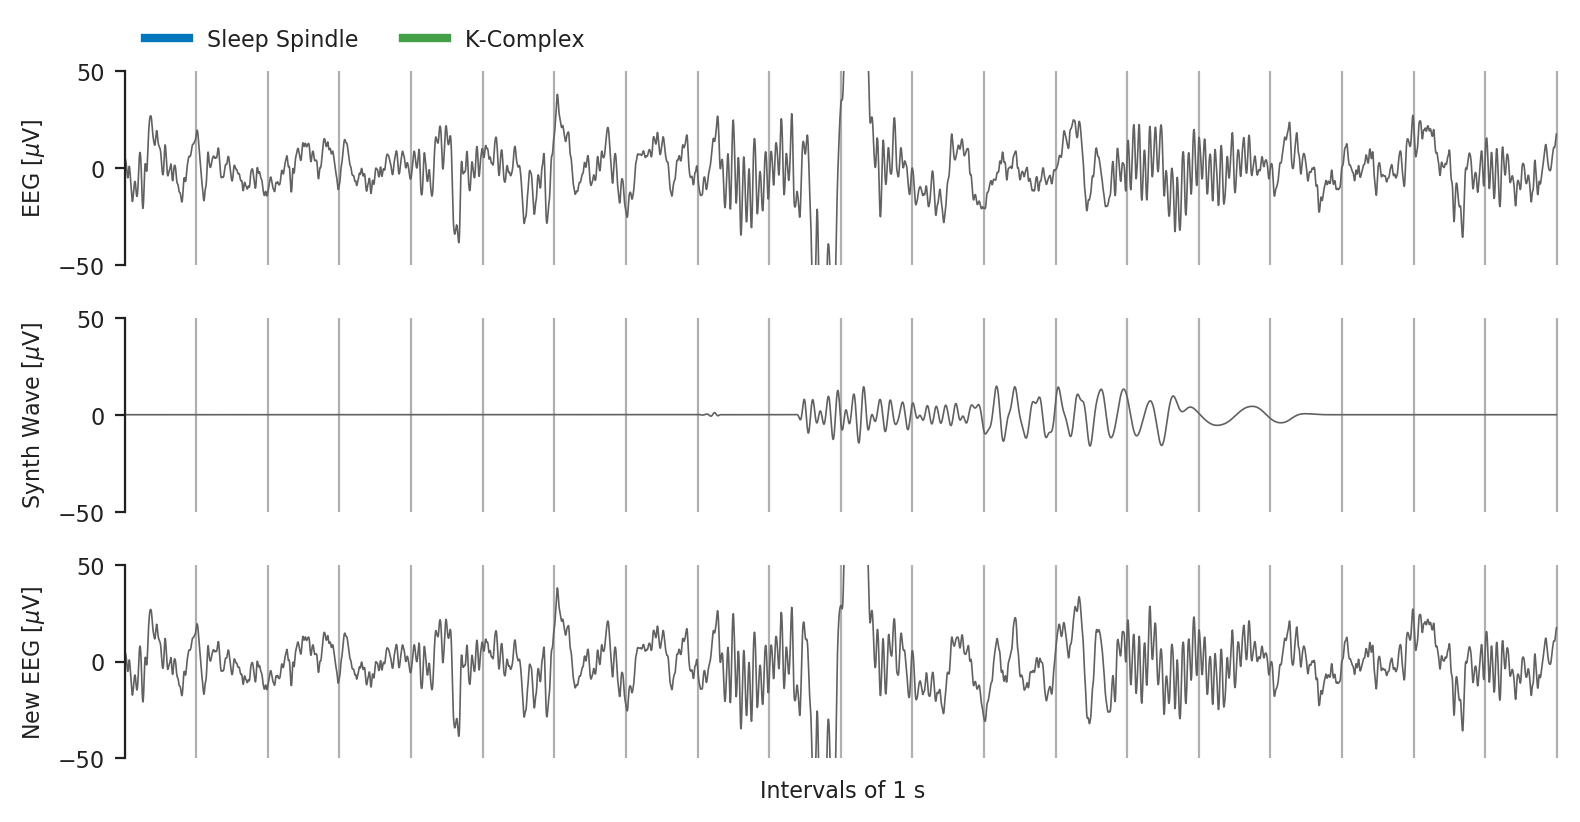

In [121]:
tf.reset_default_graph()

# 1-2 Hz
random_wave_tf = generate_wave_tf(
    segment_signal.size, fs,
    max_amplitude=30,  
    min_frequency=1,
    max_frequency=2,
    frequency_deviation=0.5,  
    min_duration=3,
    max_duration=5,
    labels_for_masking=None
)
# 2-4 Hz
random_wave_tf += generate_wave_tf(
    segment_signal.size, fs,
    max_amplitude=20,  
    min_frequency=2,
    max_frequency=4,
    frequency_deviation=1,  
    min_duration=2,
    max_duration=5,
    labels_for_masking=None
)
# 5-7 Hz (only outside SS)
random_wave_tf += generate_wave_tf(
    segment_signal.size, fs,
    max_amplitude=15,  
    min_frequency=5,
    max_frequency=7,
    frequency_deviation=2,  
    min_duration=1,
    max_duration=5,
    labels_for_masking=segment_label_ss
)
# 8-10 Hz (only outside SS)
random_wave_tf += generate_wave_tf(
    segment_signal.size, fs,
    max_amplitude=15,  
    min_frequency=8,
    max_frequency=10,
    frequency_deviation=2,  
    min_duration=1,
    max_duration=5,
    labels_for_masking=segment_label_ss
)
# 18-25 Hz (only outside SS)
#random_wave_tf += generate_wave_tf(
#     segment_signal.size, fs,
#     max_amplitude=10,  
#    min_frequency=18.5,
#     max_frequency=25,
#    frequency_deviation=2,  
#    min_duration=1,
#    max_duration=5,
#    labels_for_masking=segment_label_ss
#)
# Maybe theta and alpha everywhere including inside SS, but very small
# 5-7 Hz 
random_wave_tf += generate_wave_tf(
    segment_signal.size, fs,
    max_amplitude=5,  
    min_frequency=5,
    max_frequency=7,
    frequency_deviation=2,  
    min_duration=1,
    max_duration=5,
    labels_for_masking=None
)
# 8-10 Hz 
random_wave_tf += generate_wave_tf(
    segment_signal.size, fs,
    max_amplitude=5,  
    min_frequency=8,
    max_frequency=10,
    frequency_deviation=2,  
    min_duration=1,
    max_duration=5,
    labels_for_masking=None
)


new_signal_tf = random_wave_tf + segment_signal

with tf.Session() as sess:
    new_signal, random_wave = sess.run([new_signal_tf, random_wave_tf])
    

fig, axes = plt.subplots(3, 1, dpi=200, figsize=(8, 4))
for ax_num, ax, this_signal, name in zip(
    range(3), axes, [segment_signal, random_wave, new_signal], ["EEG", "Synth Wave", "New EEG"]):
    ax.plot(time_axis, this_signal, linewidth=0.6, color=signal_color)
    stamp_label_used = False
    if ax_num != 1:
        for stamp in segment_stamps_ss:
            if stamp_label_used:
                label = None
            else:
                label = 'Sleep Spindle'
                stamp_label_used = True
            ax.plot(
                [stamp[0] / fs, stamp[1] / fs + ss_correction_right], [-70, -70], label=label, 
                color=ss_color, linewidth=linewidth_mark)
        stamp_label_used = False
        for stamp in segment_stamps_kc:
            if stamp_label_used:
                label = None
            else:
                label = 'K-Complex'
                stamp_label_used = True
            ax.plot(
                stamp / fs, [-70, -70], label=label, 
                color=kc_color, linewidth=linewidth_mark)
    ax.set_ylabel('%s [$\mu$V]' % name, fontsize=viz.FONTSIZE_GENERAL)
    ax.set_yticks([-50, 0, 50])
    ax.set_xlim([time_axis[0], time_axis[-1]+0.05])
    ax.set_ylim([-50, 50])
    ax.set_xticks([])
    ax.set_xticks(np.arange(time_axis[0], time_axis[-1]+0.1, 1), minor=True)
    ax.grid(b=True, axis='x', which='minor')
    ax.tick_params(labelsize=viz.FONTSIZE_GENERAL)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.tick_params(axis='x', which='both',length=0)
    if ax_num == 0:
        lg = ax.legend(loc='lower left', bbox_to_anchor=(0,1), ncol=3, fontsize=viz.FONTSIZE_GENERAL, frameon=False)
        for lh in lg.legendHandles:
            lh.set_alpha(min(2 * alpha, 1.0))
        # Change color of plot
        plt.setp(lg.get_texts(), color=general_color)
    ax = plotter.set_axis_color(ax, general_color)
axes[-1].set_xlabel('Intervals of 1 s', fontsize=viz.FONTSIZE_GENERAL)
plt.tight_layout()
plt.show()

### Random wave attenuation

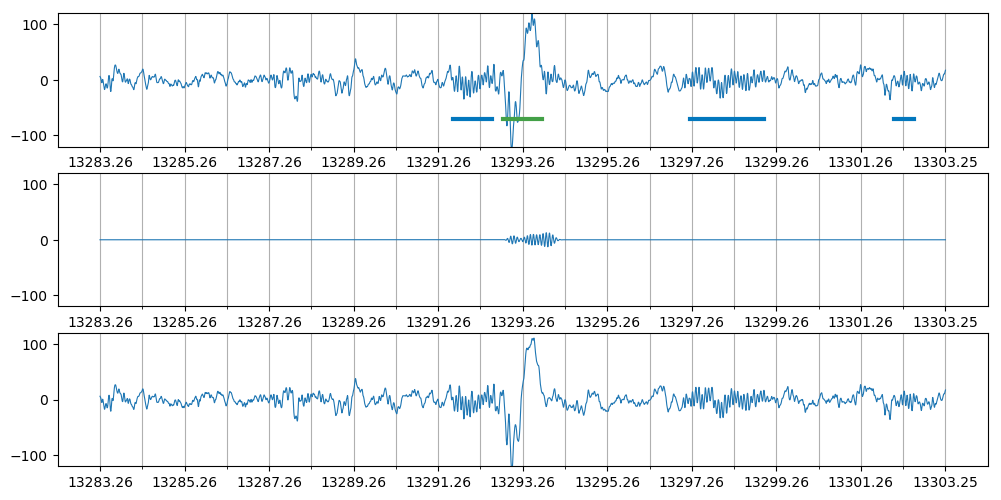

In [92]:
tf.reset_default_graph()
random_wave_tf = generate_anti_wave_tf(
    segment_signal,
    segment_signal.size, fs,
    max_attenuation=1,  
    lowcut=11,  #8
    highcut=16,  #10
    min_duration=1,  #1
    max_duration=5,  #5
    # labels_for_masking=segment_label_ss
)
new_signal_tf = random_wave_tf + segment_signal

with tf.Session() as sess:
    new_signal, random_wave = sess.run([new_signal_tf, random_wave_tf])
fig, axes = plt.subplots(3, 1, figsize=(12, 6), dpi=100)
axes[0].plot(time_axis, segment_signal, linewidth=0.8)
axes[1].plot(time_axis, random_wave, linewidth=0.8)
axes[2].plot(time_axis, new_signal, linewidth=.8)
for stamp in segment_stamps_ss:
    axes[0].plot(
        [stamp[0] / fs, stamp[1] / fs + ss_correction_right], [-70, -70], 
        color=ss_color, linewidth=linewidth_mark)
for stamp in segment_stamps_kc:
    axes[0].plot(
        stamp / fs, [-70, -70],
        color=kc_color, linewidth=linewidth_mark)
for ax in axes:
    ax.set_xticks(np.linspace(time_axis[0], time_axis[-1], 21), minor=True)
    ax.set_xticks(np.linspace(time_axis[0], time_axis[-1], 11))
    ax.grid(axis="x", which="minor")
    ax.set_ylim([-120,120])
plt.show()

### Many random waves attenuations

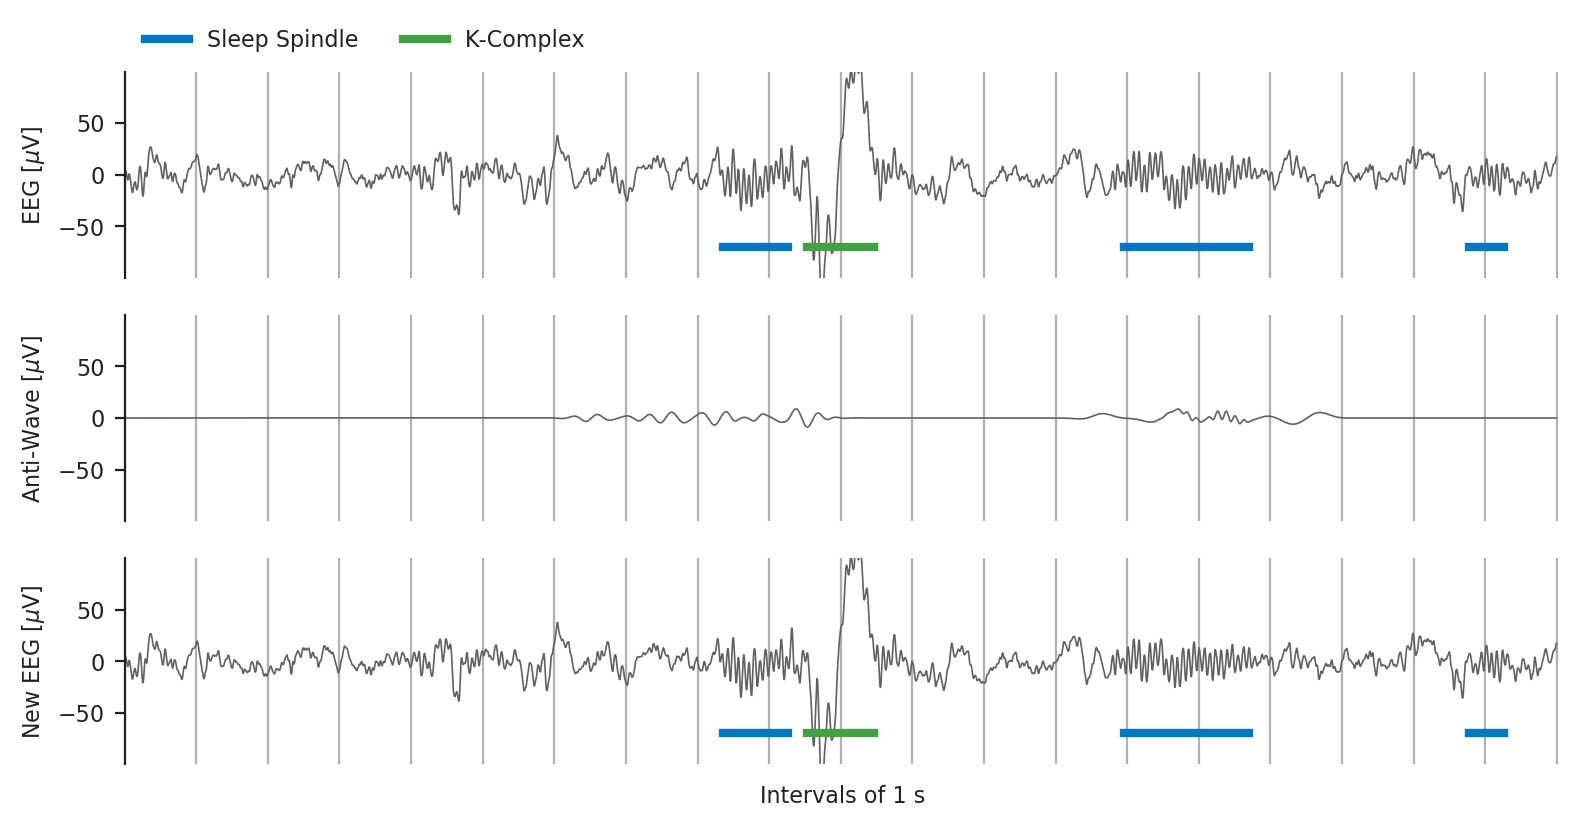

In [110]:
tf.reset_default_graph()

# Delta slow
random_wave_tf = generate_anti_wave_tf(
    segment_signal,
    segment_signal.size, fs,
    lowcut=None,
    highcut=2,
    min_duration=3,
    max_duration=5,
    labels_for_masking=None
)
# Delta fast
random_wave_tf += generate_anti_wave_tf(
    segment_signal,
    segment_signal.size, fs,
    lowcut=2,
    highcut=4,
    min_duration=2,
    max_duration=5,
    labels_for_masking=None
)
# Theta (only inside SS)
random_wave_tf += generate_anti_wave_tf(
    segment_signal,
    segment_signal.size, fs,
    lowcut=4,
    highcut=7,
    min_duration=1,
    max_duration=5,
    labels_for_masking=(1 - segment_label_ss)
)
# Alpha (only inside SS)
random_wave_tf += generate_anti_wave_tf(
    segment_signal,
    segment_signal.size, fs,
    lowcut=7,
    highcut=10,
    min_duration=1,
    max_duration=5,
    labels_for_masking=(1 - segment_label_ss)
)
# Sigma (only outside SS)
random_wave_tf += generate_anti_wave_tf(
    segment_signal,
    segment_signal.size, fs,
    lowcut=11,
    highcut=16,
    min_duration=1,
    max_duration=5,
    labels_for_masking=segment_label_ss
)


new_signal_tf = random_wave_tf + segment_signal

with tf.Session() as sess:
    new_signal, random_wave = sess.run([new_signal_tf, random_wave_tf])
    

fig, axes = plt.subplots(3, 1, dpi=200, figsize=(8, 4))
for ax_num, ax, this_signal, name in zip(
    range(3), axes, [segment_signal, random_wave, new_signal], ["EEG", "Anti-Wave", "New EEG"]):
    ax.plot(time_axis, this_signal, linewidth=0.6, color=signal_color)
    stamp_label_used = False
    if ax_num != 1:
        for stamp in segment_stamps_ss:
            if stamp_label_used:
                label = None
            else:
                label = 'Sleep Spindle'
                stamp_label_used = True
            ax.plot(
                [stamp[0] / fs, stamp[1] / fs + ss_correction_right], [-70, -70], label=label, 
                color=ss_color, linewidth=linewidth_mark)
        stamp_label_used = False
        for stamp in segment_stamps_kc:
            if stamp_label_used:
                label = None
            else:
                label = 'K-Complex'
                stamp_label_used = True
            ax.plot(
                stamp / fs, [-70, -70], label=label, 
                color=kc_color, linewidth=linewidth_mark)
    ax.set_ylabel('%s [$\mu$V]' % name, fontsize=viz.FONTSIZE_GENERAL)
    ax.set_yticks([-50, 0, 50])
    ax.set_xlim([time_axis[0], time_axis[-1]+0.05])
    ax.set_ylim([-100, 100])
    ax.set_xticks([])
    ax.set_xticks(np.arange(time_axis[0], time_axis[-1]+0.1, 1), minor=True)
    ax.grid(b=True, axis='x', which='minor')
    ax.tick_params(labelsize=viz.FONTSIZE_GENERAL)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.tick_params(axis='x', which='both',length=0)
    if ax_num == 0:
        lg = ax.legend(loc='lower left', bbox_to_anchor=(0,1), ncol=3, fontsize=viz.FONTSIZE_GENERAL, frameon=False)
        for lh in lg.legendHandles:
            lh.set_alpha(min(2 * alpha, 1.0))
        # Change color of plot
        plt.setp(lg.get_texts(), color=general_color)
    ax = plotter.set_axis_color(ax, general_color)
axes[-1].set_xlabel('Intervals of 1 s', fontsize=viz.FONTSIZE_GENERAL)
plt.tight_layout()
plt.show()